# L'analyse des utilisateurs

On cherche à analyser les données du fichier train_users_2.csv. 

In [121]:
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

On va importer les données, ajouter la variable "destination_found" qui aura pour valeur NDF ("No Destination Found") ou DF (Destination Found) et rééquilibrer les classes NDF et DF en selectionant $n$ données de chaque classe. Ici, $n=88000$. On finit par mélanger les données.

In [2]:
users = pd.read_csv('./data/train_users_2.csv', sep=',')

n = 88000
users['destination_found'] = users.apply(lambda r: 'NDF' if r['country_destination'] == 'NDF' else 'DF', axis=1)
users = pd.concat([users[users['destination_found'] == 'NDF'].head(n), users[users['destination_found'] == 'DF'].head(n)]).sample(frac=1).reset_index(drop=True)

In [12]:
users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_found
0,64yusuhwwv,2014-02-21,20140221011653,2014-09-17,MALE,26.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US,DF
1,qrs8pbb6ll,2013-12-20,20131220160249,2014-01-05,FEMALE,27.0,basic,0,en,direct,direct,linked,Web,Windows Desktop,Firefox,US,DF
2,thh4s2yp7w,2014-01-31,20140131175826,2014-02-05,-unknown-,19.0,basic,0,en,direct,direct,linked,Web,Mac Desktop,Firefox,other,DF
3,me67q4003s,2012-11-17,20121117230804,2012-12-04,MALE,45.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Safari,US,DF
4,9gyv4bkvij,2013-06-30,20130630234058,NaN,MALE,36.0,facebook,0,en,direct,direct,untracked,Web,Windows Desktop,Chrome,NDF,NDF


## Analyse des données générales

### Gender

OTHER : 261 représentants


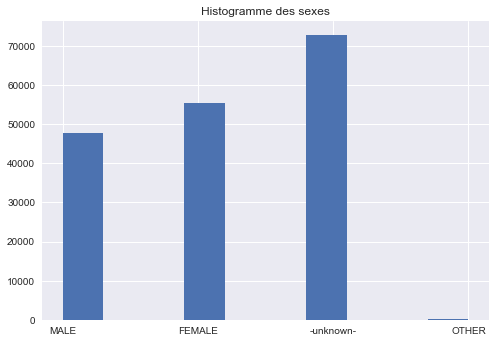

In [138]:
_ = plt.hist(users['gender'])
plt.title("Histogramme des sexes")
print(f"OTHER : {users[users['gender'] == 'OTHER'].shape[0]} représentants")

On distingue 4 valeurs possibles pour "gender" : "MALE", "FEMALE", "-unknown-" et OTHER. La valeur "-unknown-" est majoritairement représentée. On voit qu'il y a un peu plus de femme que d'homme dans ces données. La valeur "OTHER" est sous représentée avec seulement 261 représentants. La pluplart des utilisateurs ne donnent pas d'information concernant leur sexe. Vérifions s'il n'y aurait pas de corrélation avec les variables cibles.

gender             -unknown-  FEMALE   MALE  OTHER
destination_found                                 
DF                     28685   31684  27456    175
NDF                    44101   23629  20184     86


Text(0.5, 1.0, 'Proportion des sexes selon la destination')

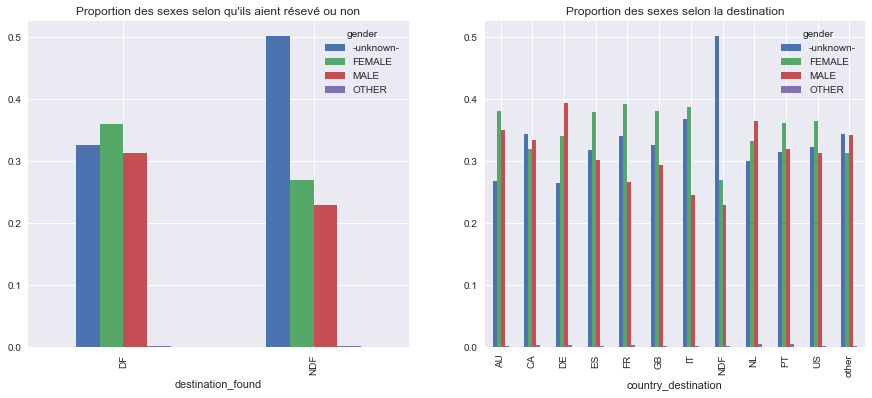

In [139]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
var = pd.crosstab(users['destination_found'], users['gender'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax1)
ax1.set_title("Proportion des sexes selon qu'ils aient résevé ou non")
print(var)

var = pd.crosstab(users['country_destination'], users['gender'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
ax2.set_title("Proportion des sexes selon la destination")

On remarque que la valeur "-unknown" est très présente parmi les NDF. Par aiilleurs, les utilisateurs qui ont renseigné leur sexe ont tendence à réserver.

Au niveau de la distribution par pays, on voit que les utilisateurs ayant réservé en Allemagne (DE) et aux Pays-Bas (NL) sont plus généralement des hommes tandis que celles ayant réservé en Italie (IT), France (FR) et Grande-Bretagne (GB) sont plus souvent des femmes. Pour les autres pays, la différence est trop faible pour établir une quelconque conclusion. Souvent, il peut être normalement de voir que le nombre de femmes est légèrement supérieur au nombre d'homme chez certains pays puisque le nombre total de femmes dans ces données supérieur à celui de l'homme.

### Age

0.25    29.0
0.50    34.0
0.75    42.0
Name: age, dtype: float64


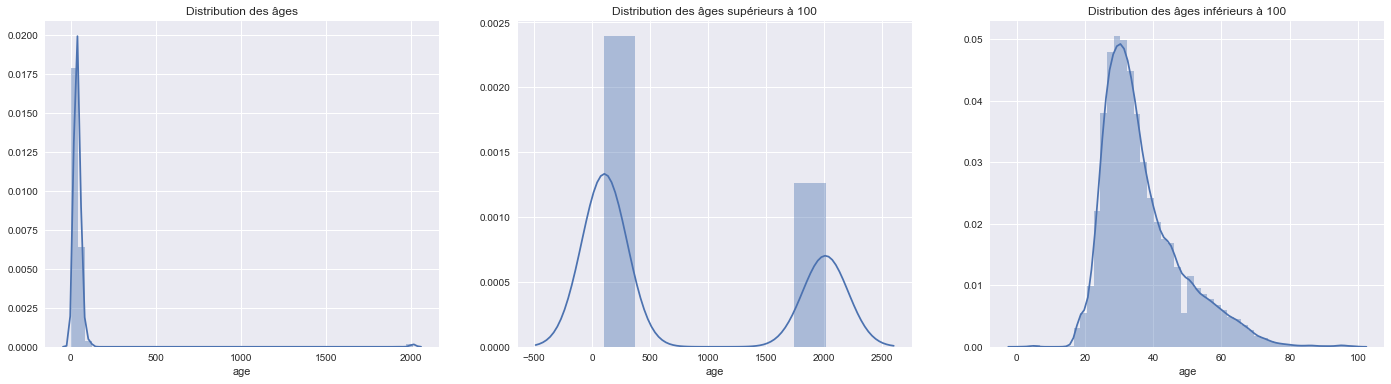

In [95]:
f = plt.figure(figsize=(24, 6))
f.add_subplot(1, 3, 1)
sns.distplot(users['age'])
plt.title("Distribution des âges")

f.add_subplot(1, 3, 2)
sns.distplot(users[users['age'] >= 100]['age'])
plt.title("Distribution des âges supérieurs à 100")

f.add_subplot(1, 3, 3)
sns.distplot(users[users['age'] < 100]['age'])
plt.title("Distribution des âges inférieurs à 100")

print(users[users['age'] < 100]['age'].quantile([0.25, 0.5, 0.75]))

Ici, on voit clairement que l'âge est erroné (certaines personnes auraient plus de 2000 ans). Il est possible que des individus aient renseignés leur années de naissance à la place de leur âge ou ayant sélectionné l'année par défaut (souvent l'année de la création du compte, aux alentours de 2014).
Plusieurs remarques :
* l'âge médian est de 34 ans. 
* un groupe de personnes ont indiqué un âge proche des 2000 ans ; on supposera qu'ils ont confondu l'âge et l'année de naissance.
* un groupe de personnes ont indiqué un âge proche de 2014 ; on supposera qu'ils s'agit de l'année par défaut et (qu'au delà de 2000) ils n'ont donc renseigné aucune valeur.
* un groupe de personnes ont donné un âge qui avoisine des 200 ans.

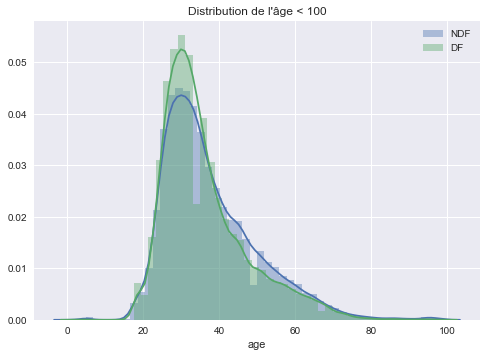

In [141]:
sns.distplot(users[(users['destination_found'] == 'NDF') & (users['age'] < 100)]['age'], label='NDF')
sns.distplot(users[(users['destination_found'] == 'DF') & (users['age'] < 100)]['age'], label='DF')
plt.title("Distribution de l'âge < 100")
plt.legend()

Les individus marqués comme étant DF ont un âge légèrement plus centré vers les 30 ans que ceux marqués comme étant NDF. Ces derniers ont une population qui est légèrement plus importante au niveau des 50 ans. Autrement, peu d'éléments peuvent en être déduites ; les données sur l'âge des types de population sont relativement proches. 

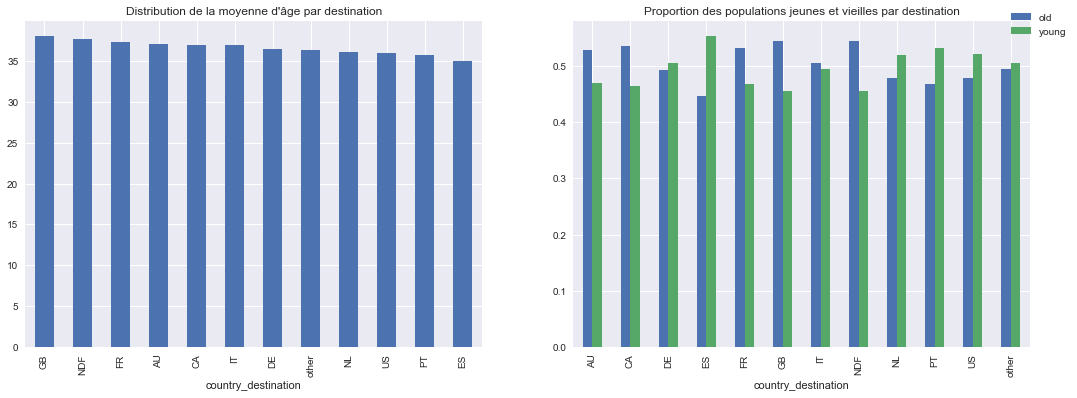

In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
destination_ages = users[users['age'] < 100].groupby('country_destination').agg({'age': np.mean})['age'].sort_values(ascending=False)
destination_ages.plot(kind='bar', ax=ax1)
ax1.set_title("Distribution de la moyenne d'âge par destination")

users['age_category'] = users.apply(lambda r: 'young' if r['age'] < 34 else 'old', axis=1)
var = pd.crosstab(users[users['age'] < 100]['country_destination'], users[users['age'] < 100]['age_category'])
var.div(var.sum(1).astype(float), axis=0).plot(kind="bar", stacked=False, ax=ax2)
ax2.set_title("Proportion des populations jeunes et vieilles par destination")
plt.legend(bbox_to_anchor=(1.1, 1.05))
users = users.drop('age_category', axis=1)

On peut voir que les utilisateurs qui ont effectué une réservation en Grande-Bretagne (GB), France (FR), Canada (CA) ou Australie (AU) ont tendance a être plus âgés que le reste. À l'inverse, les utilisateurs ayant réservé en Espagne (ES), Portugal (PT) ou aux Etats-Unis (US) ont tendance à être plus jeune. Les utilisiateurs n'aynt fait de réservation tendent à être plus âgé également. Cela rejoint notre observation sous le graphique précédent.

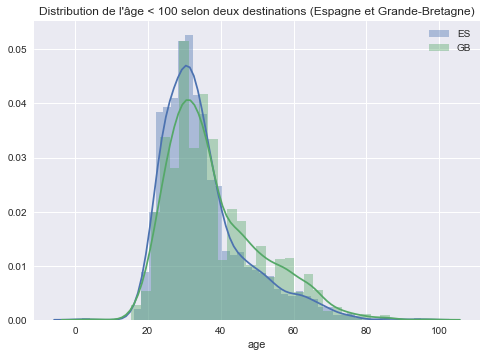

In [146]:
sns.distplot(users[(users['country_destination'] == 'ES') & (users['age'] < 100)]['age'], label='ES')
sns.distplot(users[(users['country_destination'] == 'GB') & (users['age'] < 100)]['age'], label='GB')
plt.title("Distribution de l'âge < 100 selon deux destinations (Espagne et Grande-Bretagne)")
plt.legend()

Cependant, en mettant en contraste les extrêmes, on voit que la population des 40 à 70 ans est légèrement plus importante parmi ceux ayant réservé en Grande-Bretagne (GB) qu'en Espagne. Ceux ayant fait une réservation en Espagne ont une population plus importante dans la tranche d'âges [20, 25]. Les tranches d'âges citées ici seront utile pour catégoriser l'âge des individus. En effet, il serait intéressant de créer des groupes par tranche d'âge ; notament [20, 25] et [40, 70] par exemple afin de mieux séparer nos indvidus.

Néanmoins, les données restent peu séparables dans ce cas.

## Analyse des données liées au temps